## Training the Model

In [1]:
!pip install duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 9.8 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.data.external import *
from time import sleep

In [13]:
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

# collect several examples of various African animals
searches = 'lion', 'cheetah', 'rhino', 'hippo', 'boerperd'
path = Path('African animals')

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{search} female photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{search} male photo'))
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

Searching for 'lion female photo'
Searching for 'lion male photo'
Searching for 'cheetah female photo'
Searching for 'cheetah male photo'
Searching for 'rhino female photo'
Searching for 'rhino male photo'
Searching for 'hippo female photo'
Searching for 'hippo male photo'
Searching for 'boerperd female photo'
Searching for 'boerperd male photo'


In [14]:
# check if images have downloaded correctly and remove any that haven't
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(len(failed))

1


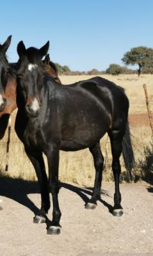

In [15]:
# view an image of a boerperd
subdir = path/'boerperd'
file_lst = [file for file in subdir.iterdir()]

img = Image.open(file_lst[0])
img.to_thumb(256, 256)

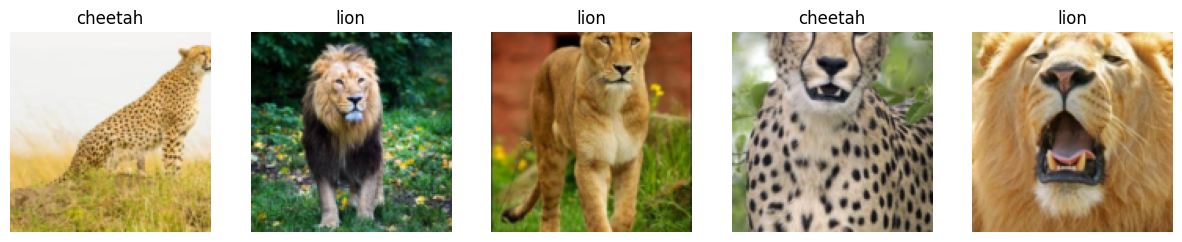

In [16]:
# to train a model, we need DataLoaders - an object containing the
# training and validation sets. It can be created using a DataBlock in
# fastai
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
    )
dls = animals.dataloaders(path)

# and view a batch of 5 images from the validation set
dls.valid.show_batch(max_n=5, nrows=1)

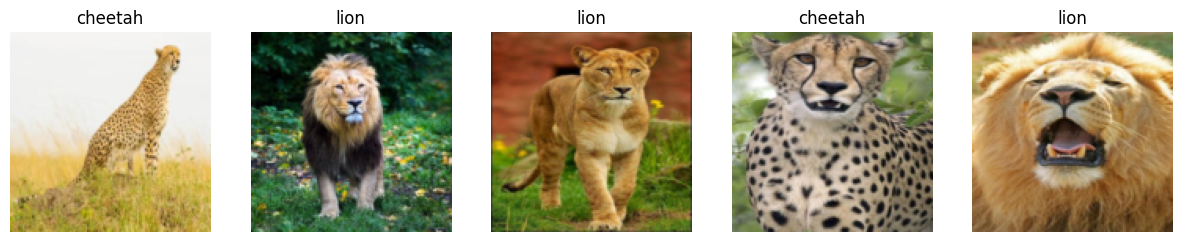

In [17]:
# by default, Resize crops images to fit the size requested, you can also 'squish'
animals = animals.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

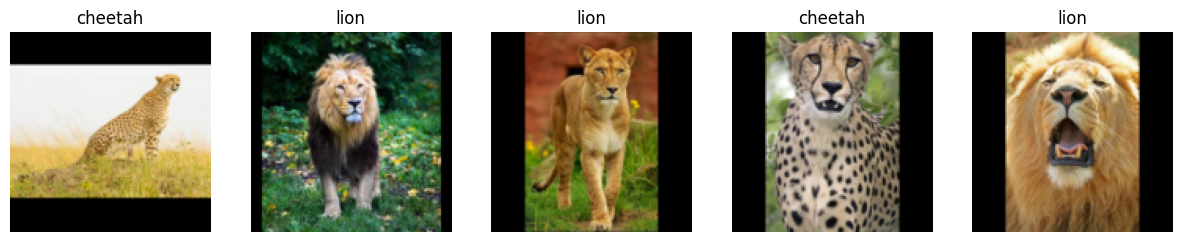

In [18]:
# ... or pad
animals = animals.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

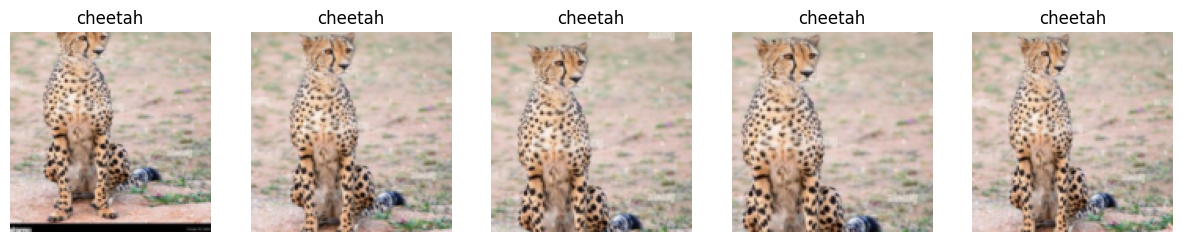

In [19]:
# ... or randomly crop an image
animals = animals.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

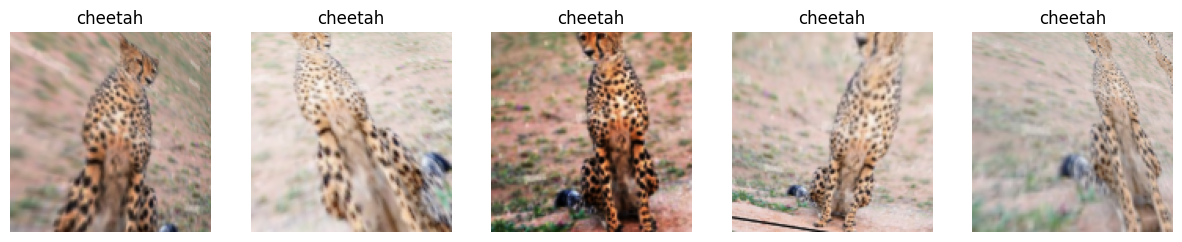

In [20]:
# 'augment' a single image to create new versions of that same image
animals = animals.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

In [21]:
# create the final dataset with an image size of 224 and default aug_transforms
# aug_transforms requires num_workers=0 in dataloaders on windows machines
animals_final = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
    )
dls = animals_final.dataloaders(path, num_workers=0)

# fine-tune a pretrained resnet18 cnn
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

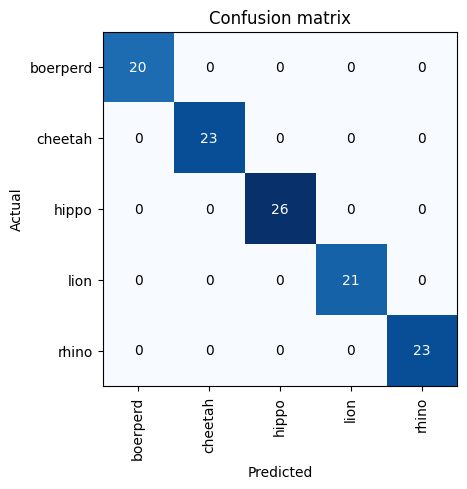

In [22]:
# generate a confusion matrix to see where the errors are occurring
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

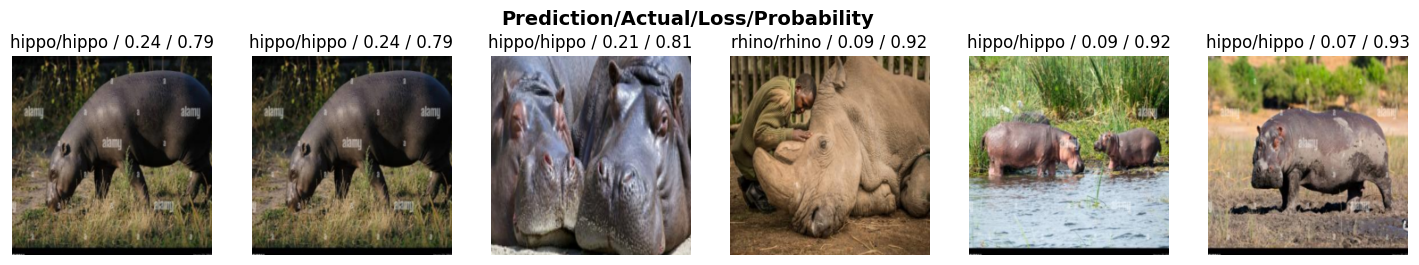

In [23]:
# display the images with the highest loss
interp.plot_top_losses(6, nrows=1)

In [24]:
from fastai.vision.widgets import *

# fix data issues (e.g. misslabelled images, images that shouldn't be there)
# (this is a widget and only works in interactive mediums like a notebook)
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# delete images marked for deletion in cleaner
# for idx in cleaner.delete():
#     cleaner.fns[idx].unlink()
# move images where the class has been changed
# for idx,cat in cleaner.change():
#     shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# retrain the model on the cleaned data
animals_clean = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
    )
dls = animals_clean.dataloaders(path, num_workers=0)

# fine-tune a pretrained resnet18 cnn
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

## Turning the Model into an Online Application

In [26]:
# save the model
learn.export('model.pkl')

# check that it exists
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('model.pkl'),Path('export.pkl')]

In [28]:
# load the saved model
learn_inf = load_learner(path/'model.pkl')

# make a prediction for a single image
subdir = path/'African animals'/'lion'
file_lst = [file for file in subdir.iterdir()]
learn_inf.predict(file_lst[0])

('lion',
 tensor(3),
 tensor([4.4522e-08, 9.5771e-06, 7.5717e-07, 9.9999e-01, 9.2108e-07]))

In [29]:
# check the possible classes
learn_inf.dls.vocab

['boerperd', 'cheetah', 'hippo', 'lion', 'rhino']